# Detecting Visuo-Haptic Mismatches in Virtual Reality using the Prediction Error Negativity of Event-Related Brain Potentials.
### Reimplementation and finding. 

Students: 
1. Yonatan 
2. Shkahnukova Milana, 3730348

In [32]:
from pathlib import Path
import mne

In this report, we are focusing on reimplementing the paper focused on analyzing the **prediction error negativity between the mismatches in virtual reality** for visuo-haptic motions. The primary goal of the original study is to **detect visuo-haptic mismatches**—situations where the visual and haptic feedback are incongruent —using electroencephalography (EEG) to monitor **event-related potentials (ERPs)**. To analyze these haptic conflicts that can **disrupt the user experience** in VR, the early negativity components of ERPs were used.

Note:  we need the EEG data to work with. Use the `ds003846-1sh` script in this repo to download the data. The data is organized into folders by subject, and each folder has sessions for different conditions.

# Re-implementation pipeline

1. Load the dataset and make adjustments to ensure the file names match correctly.
2. Preprocessing: Filter and downsample the data. 
3. ICA analysis.

## Step 1. Dataset Loading

The channel names in the dataset have a prefix ("BrainVision RDA_") that is specific to the recording system We need to remove this prefix to match the standard EEG channel naming convention (e.g., "Fp1", "Fz")

In this step we add a reference channel which is a FCz for us as it it provides a balanced reference point for neural activity across the scalp. In addition, we set teh standard Standard 10-20 Electrode Placement to make sure the electrode positions are correctly assigned according to a standardized layout and we can futher visualizing EEG topographies, as it can be seen on the graph below.

In [33]:
from src.data_loader import load_raw_sessions

In [34]:
subject = "sub-02"
base_path = Path("/Users/Milana/Documents/university/eeg_block/prediction_error_EEG/ds003846-2.0.2")
raw_sessions = load_raw_sessions(base_path,
                                subject)
data_paths = {
    "ses-EMS": base_path / subject / "ses-EMS" / "eeg",
    "ses-Visual": base_path / subject / "ses-Visual" / "eeg",
    "ses-Vibro": base_path / subject / "ses-Vibro" / "eeg"
}

Loading data for ses-EMS from /Users/Milana/Documents/university/eeg_block/prediction_error_EEG/ds003846-2.0.2/sub-02/ses-EMS/eeg/sub-02_ses-EMS_task-PredictionError_eeg.vhdr...
Extracting parameters from /Users/Milana/Documents/university/eeg_block/prediction_error_EEG/ds003846-2.0.2/sub-02/ses-EMS/eeg/sub-02_ses-EMS_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 258029  =      0.000 ...   516.064 secs...
Loading data for ses-Visual from /Users/Milana/Documents/university/eeg_block/prediction_error_EEG/ds003846-2.0.2/sub-02/ses-Visual/eeg/sub-02_ses-Visual_task-PredictionError_eeg.vhdr...
Extracting parameters from /Users/Milana/Documents/university/eeg_block/prediction_error_EEG/ds003846-2.0.2/sub-02/ses-Visual/eeg/sub-02_ses-Visual_task-PredictionError_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 959079  =      0.000 ...  1918.184 secs...
Loading data for ses-Vibro from /Users/Milana/Documents/university/eeg_block/prediction_error_EEG

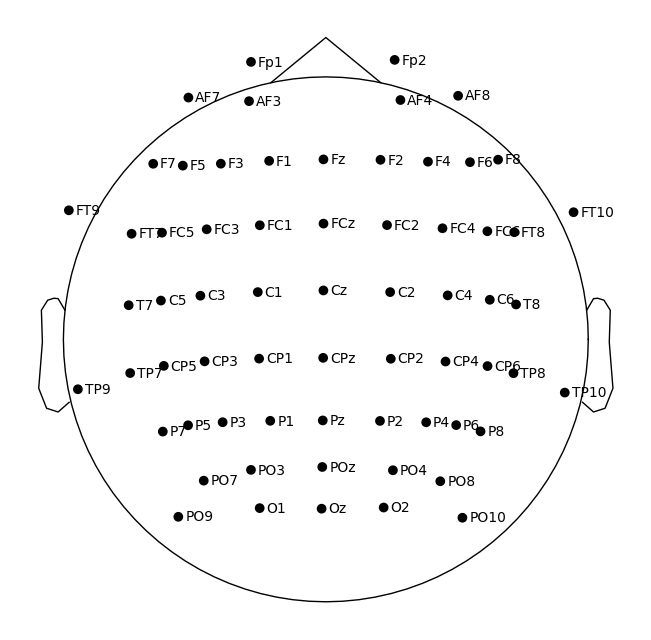

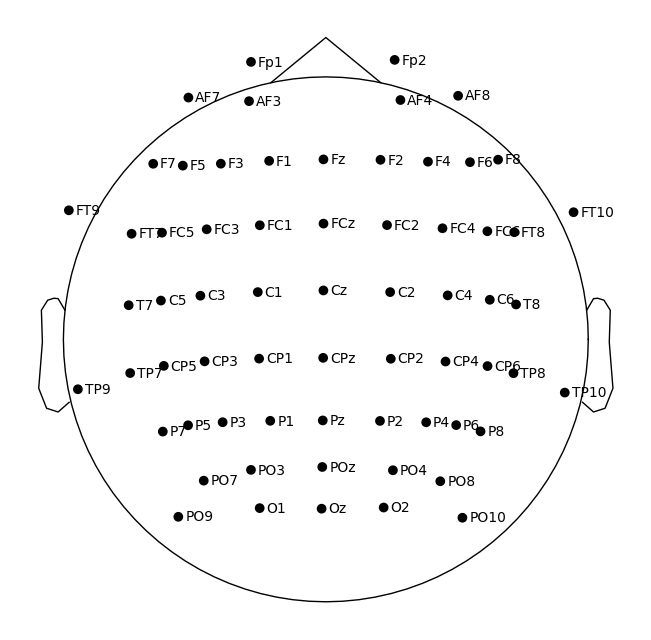

In [35]:
raw_sessions["ses-EMS"].plot_sensors(kind="topomap", show_names=True)

## Step 2. Filter and downsample.

On the next step we're focusing on the filtering of the data. 

ERP components are small signals, so cleaning the data is crucial for detection. Moreover, accurate preprocessing ensures that only neural activity is analyzed (not artifacts).


This step includes the following operations:
1. Bandpass filtering: removes unwanted low-frequency drifts and high-frequency noise.
2. Downsampling: retains important ERP components while removing unnecessary high-frequency detail.
3. Re-referencing: reduces signal bias and improves spatial resolution, helps balance activity across all electrodes.
4. Notch filtering: removes power line interference.

Note: the parameters for the filtering are saved in ./src/config.py


In [36]:
from src.preprocessing import preprocess_raw_sessions

In [37]:
raw_sessions = preprocess_raw_sessions(raw_sessions)


--- Preprocessing ses-EMS ---
  Filtering 1.0–124.9 Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.90 Hz
- Upper transition bandwidth: 31.23 Hz (-6 dB cutoff frequency: 140.51 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


  Downsampling to 250 Hz...
  Re-referencing to average...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
  Applying notch filter at [50] Hz...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

  ses-EMS info: 65 channels, sampling rate: 250.0 Hz

--- Preprocessing ses-Visual ---
  Filtering 1.0–124.9 Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


  Downsampling to 250 Hz...
  Re-referencing to average...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
  Applying notch filter at [50] Hz...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


  ses-Visual info: 65 channels, sampling rate: 250.0 Hz

--- Preprocessing ses-Vibro ---
  Filtering 1.0–124.9 Hz...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.90 Hz
- Upper transition bandwidth: 31.23 Hz (-6 dB cutoff frequency: 140.51 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


  Downsampling to 250 Hz...
  Re-referencing to average...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
  Applying notch filter at [50] Hz...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


  ses-Vibro info: 65 channels, sampling rate: 250.0 Hz


# Step 2.5 Sanity Checks

In [43]:
from src.sanity_checks import check_channel_statistics, plot_psd_sanity

In [45]:
for session, raw in raw_sessions.items():
    check_channel_statistics(raw, session)


Channel statistics for ses-EMS:
  Fp1: mean = -0.00, std = 0.00
  Fp2: mean = -0.00, std = 0.00
  F7: mean = -0.00, std = 0.00
  F3: mean = -0.00, std = 0.00
  Fz: mean = -0.00, std = 0.00
  F4: mean = -0.00, std = 0.00
  F8: mean = -0.00, std = 0.00
  FC5: mean = 0.00, std = 0.00
  FC1: mean = -0.00, std = 0.00
  FC2: mean = -0.00, std = 0.00
  FC6: mean = -0.00, std = 0.00
  T7: mean = 0.00, std = 0.00
  C3: mean = 0.00, std = 0.00
  Cz: mean = -0.00, std = 0.00
  C4: mean = 0.00, std = 0.00
  T8: mean = 0.00, std = 0.00
  TP9: mean = 0.00, std = 0.00
  CP5: mean = 0.00, std = 0.00
  CP1: mean = 0.00, std = 0.00
  CP2: mean = 0.00, std = 0.00
  CP6: mean = 0.00, std = 0.00
  TP10: mean = 0.00, std = 0.00
  P7: mean = 0.00, std = 0.00
  P3: mean = 0.00, std = 0.00
  Pz: mean = 0.00, std = 0.00
  P4: mean = 0.00, std = 0.00
  P8: mean = 0.00, std = 0.00
  PO9: mean = 0.00, std = 0.00
  O1: mean = 0.00, std = 0.00
  Oz: mean = 0.00, std = 0.00
  O2: mean = 0.00, std = 0.00
  PO10: mean

Plotting PSD for sanity check of ses-EMS...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).
Plotting PSD for sanity check of ses-Visual...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


/Users/Milana/anaconda3/envs/fraunhofer_env/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Plotting power spectral density (dB=True).
Plotting PSD for sanity check of ses-Vibro...
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


/Users/Milana/anaconda3/envs/fraunhofer_env/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Plotting power spectral density (dB=True).


/Users/Milana/anaconda3/envs/fraunhofer_env/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


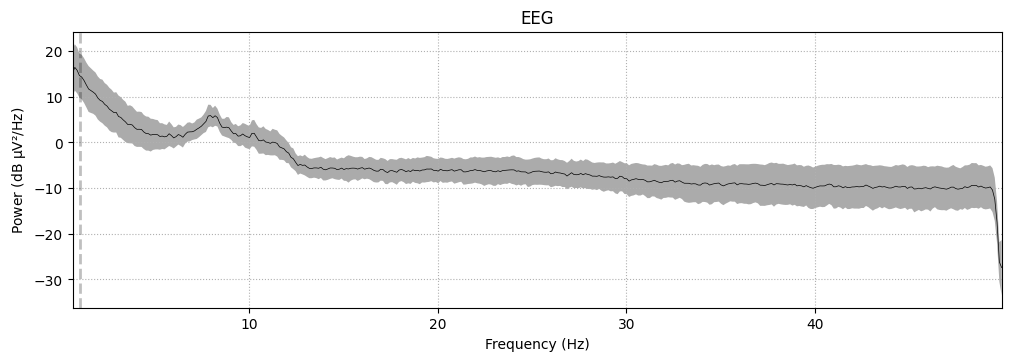

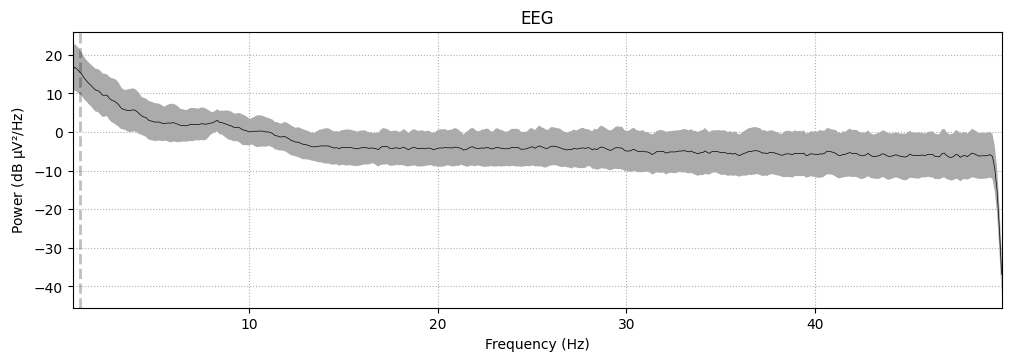

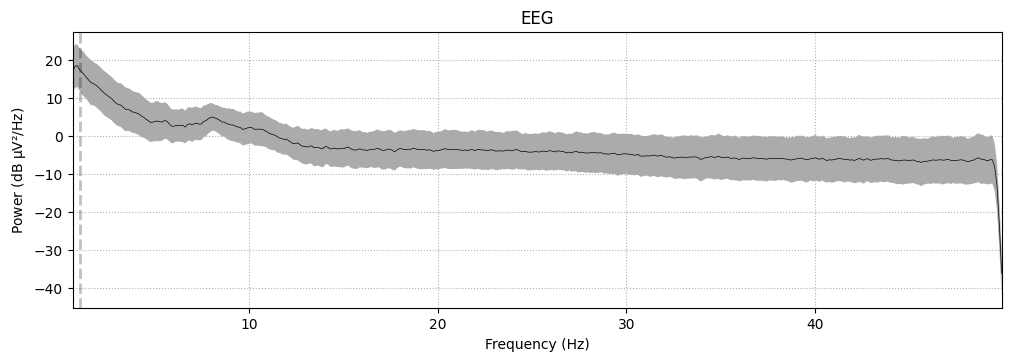

In [46]:

for session, raw in raw_sessions.items():
    plot_psd_sanity(raw, session)

From the plots above we can conclude:
1. A flat PSD curve would indicate a dead or disconnected electrode. Since no such extreme flat line appears, there are no completely dead channels, but individual channel inspection is still needed.
2. High Power at low frequencies (1–10 Hz), is significantly high in the lower frequency range, which could indicate eye movement artifacts (especially below 3 Hz). 

## Step 3. ICA analysis

ICA analysis is a necessary step to separate the eye blink activity, line noise and other artifacts.  

The paper also does this but after their intial 1 second window epoching and noisy epochs removal. We think this might be because it helps the ICA result when the data is clean. But in our pipeline we directly do the ICA analysis.

In [49]:
from src.ica import run_ica_label_exclude

ica_sessions = run_ica_label_exclude(raw_sessions)


=== ICA for ses-EMS ===
  Fitting ICA...
Fitting ICA to data using 65 channels (please be patient, this may take a while)
Selecting by number: 20 components
Computing Extended Infomax ICA
Fitting ICA took 21.5s.
  Labeling ICA components with ICLabel...


/Users/Milana/Documents/university/eeg_block/git_solution/prediction_error_EEG/src/ica.py:41: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ICLabel assigned: ['eye blink', 'eye blink', 'brain', 'eye blink', 'brain', 'brain', 'muscle artifact', 'brain', 'muscle artifact', 'brain', 'muscle artifact', 'brain', 'muscle artifact', 'brain', 'muscle artifact', 'muscle artifact', 'muscle artifact', 'other', 'muscle artifact', 'muscle artifact']
  Excluding components: [0, 1, 3, 6, 8, 10, 12, 14, 15, 16, 18, 19]
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 12 ICA components
    Projecting back using 65 PCA components

=== ICA for ses-Visual ===
  Fitting ICA...
Fitting ICA to data using 65 channels (please be patient, this may take a while)
Selecting by number: 20 components
Computing Extended Infomax ICA
Fitting ICA took 103.0s.
  Labeling ICA components with ICLabel...


/Users/Milana/Documents/university/eeg_block/git_solution/prediction_error_EEG/src/ica.py:41: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ICLabel assigned: ['muscle artifact', 'eye blink', 'eye blink', 'brain', 'muscle artifact', 'eye blink', 'muscle artifact', 'brain', 'brain', 'eye blink', 'muscle artifact', 'brain', 'muscle artifact', 'brain', 'muscle artifact', 'muscle artifact', 'muscle artifact', 'brain', 'other', 'heart beat']
  Excluding components: [0, 1, 2, 4, 5, 6, 9, 10, 12, 14, 15, 16, 19]
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 13 ICA components
    Projecting back using 65 PCA components

=== ICA for ses-Vibro ===
  Fitting ICA...
Fitting ICA to data using 65 channels (please be patient, this may take a while)
Selecting by number: 20 components
Computing Extended Infomax ICA
Fitting ICA took 81.7s.
  Labeling ICA components with ICLabel...


/Users/Milana/Documents/university/eeg_block/git_solution/prediction_error_EEG/src/ica.py:41: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


  ICLabel assigned: ['channel noise', 'eye blink', 'channel noise', 'eye blink', 'brain', 'brain', 'heart beat', 'brain', 'eye blink', 'brain', 'brain', 'brain', 'brain', 'muscle artifact', 'muscle artifact', 'muscle artifact', 'brain', 'muscle artifact', 'brain', 'muscle artifact']
  Excluding components: [0, 1, 2, 3, 6, 8, 13, 14, 15, 17, 19]
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 11 ICA components
    Projecting back using 65 PCA components


In [ ]:
As we can see ICA assigned quite a lot of labels for brain, hear beat, eye blink and channel noise components. 

Now we will visualize the raw and processed ica sessions. As we can observer, the signals for all of the sessions became less noisy and 

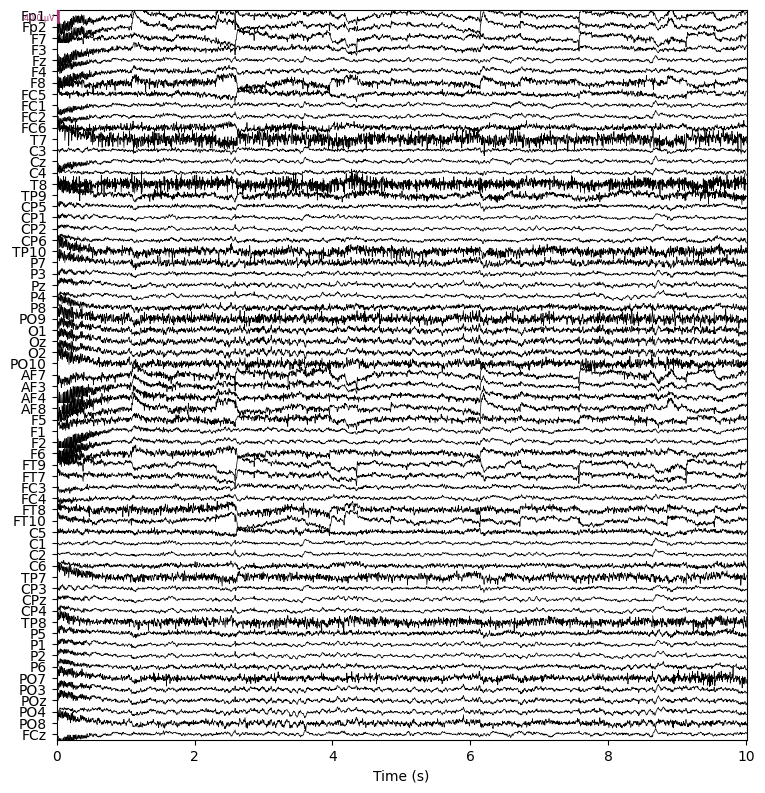

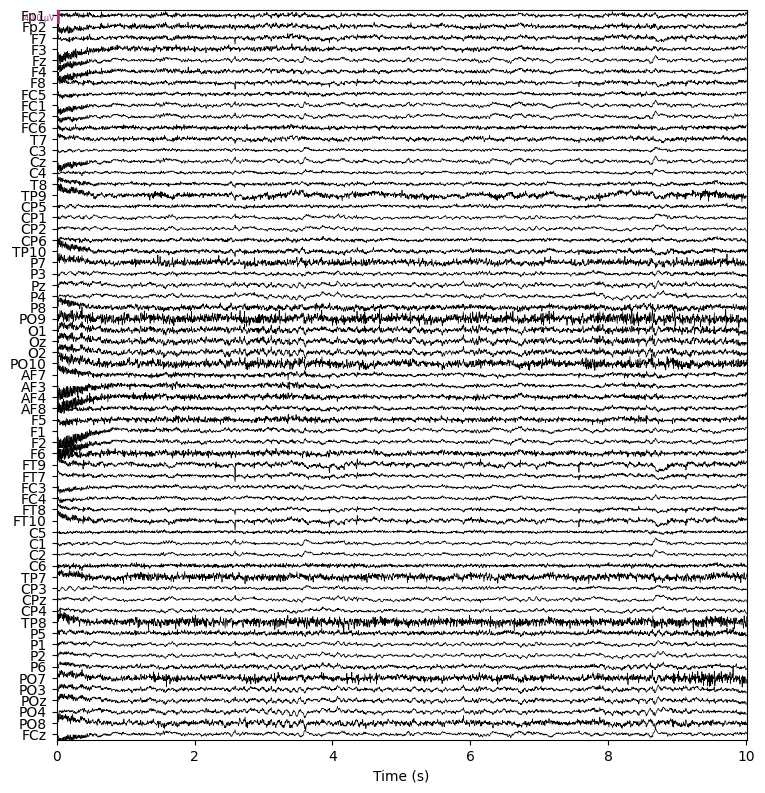

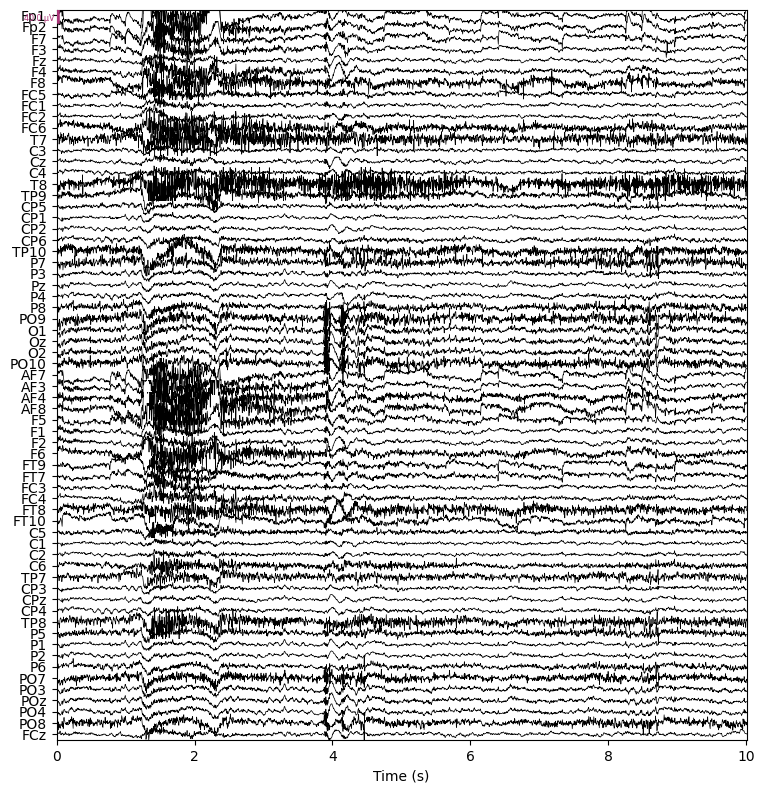

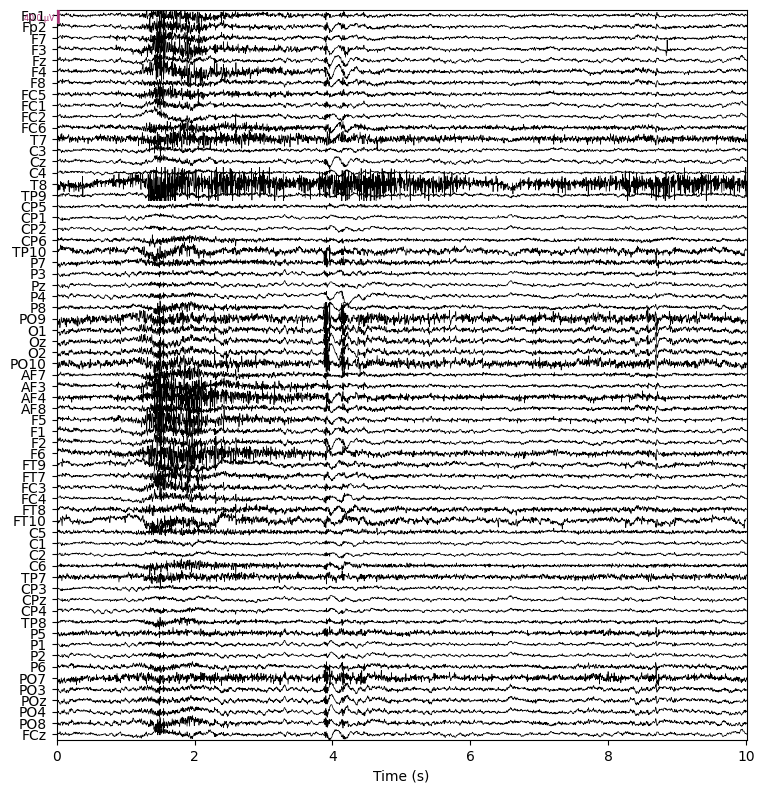

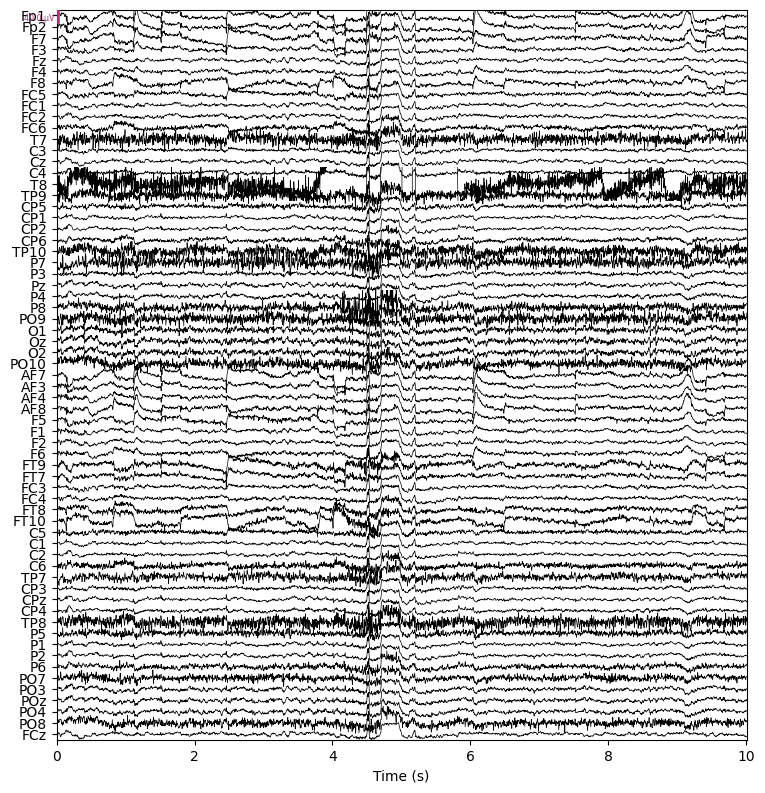

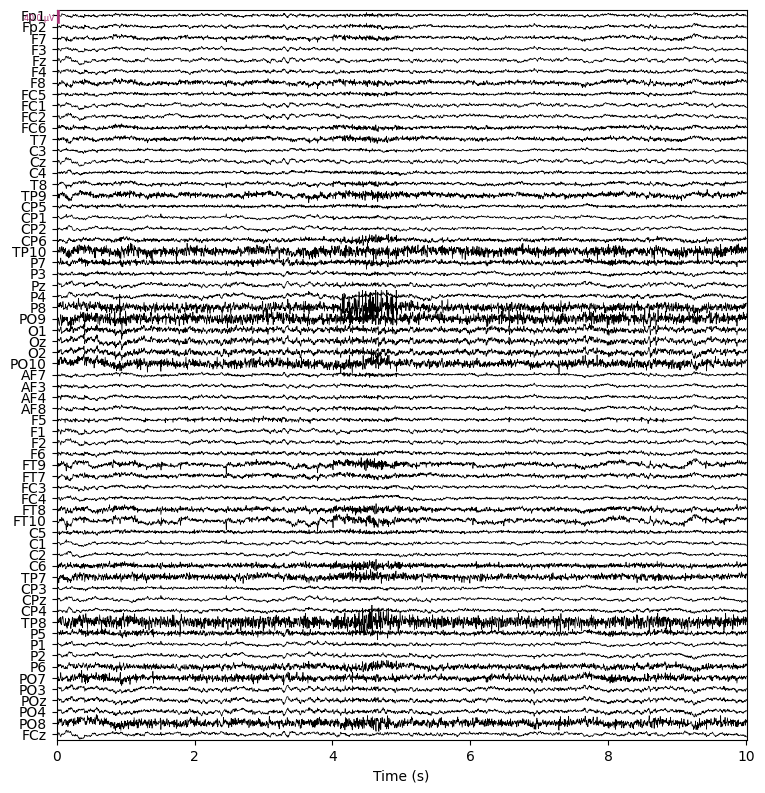

In [41]:
for raw, processed_raw in zip(raw_sessions.values(), ica_sessions.values()):

    artifact_picks = mne.pick_channels(raw.info['ch_names'], include=[])

    # Visualize the FCz channel before & after
    raw.plot(order=artifact_picks, n_channels=len(artifact_picks), show_scrollbars=False)
    processed_raw.plot(order=artifact_picks, n_channels=len(artifact_picks), show_scrollbars=False)

# Key Results

1. **Better signal quality**: Our filtering techniques significantly improved signal clarity, making it easier to detect brain responses to sensory mismatches
2. **Reduced noise**: We successfully preserved important brain signals while removing unwanted artifacts